In [2]:
import geopandas as gpd

In [3]:
intersections_fp = 'L3_data/uusimaa_intersections.gpkg'
postcode_areas_fp = 'L3_data/uusimaa_postal_code_areas.gpkg'

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

In [4]:
intersections.head()

,x,y,geometry
0,330888.502,6675829.949,POINT (330888.502 6675829.949)
1,348059.990,6670041.685,POINT (348059.990 6670041.685)
2,348022.592,6670202.858,POINT (348022.592 6670202.858)
3,297208.220,6669048.357,POINT (297208.220 6669048.357)
4,330835.341,6675586.834,POINT (330835.341 6675586.834)


In [5]:
postcode_areas.head()

,posti_alue,he_vakiy,geometry
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573..."
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279..."
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176..."
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


In [6]:
print("Number of intersections:", len(intersections))
print("Number of postal code areas:", len(postcode_areas))

Number of intersections: 63518
Number of postal code areas: 370


(6667500.0, 6680000.0)

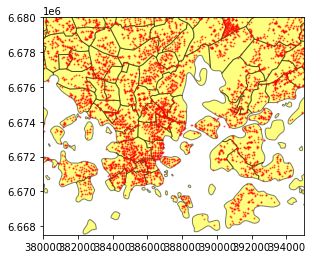

In [9]:
ax = postcode_areas.plot(color='yellow', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='red', markersize=1, alpha=0.5)

# Zoom to closer (comment out the following to see the full extent of the data)
ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])

In [10]:
intersection_sindex = intersections.sindex
intersection_sindex

rtree.index.Index(bounds=[266574.119, 6632767.892, 419357.063, 6745429.931], size=63518)

In [11]:
print("Number of groups:", len(intersection_sindex.leaves()), '\n')

# Print some basic info for few of them
n_iterations = 10
for i, group in enumerate(intersection_sindex.leaves()):
    group_idx, indices, bbox = group
    print("Group", group_idx, "contains ", len(indices), "geometries, bounding box:", bbox)
    i+=1
    if i == n_iterations:
        break

Number of groups: 908 

Group 0 contains  70 geometries, bounding box: [270305.195, 6632767.892, 279497.993, 6638674.424]
Group 2 contains  70 geometries, bounding box: [272155.57, 6638680.047, 285753.31, 6638976.355]
Group 3 contains  70 geometries, bounding box: [271904.727, 6638983.54, 286463.059, 6639181.123]
Group 4 contains  70 geometries, bounding box: [271790.007, 6639184.018, 284495.801, 6639351.784]
Group 5 contains  70 geometries, bounding box: [271952.787, 6639354.724, 284589.912, 6639564.576]
Group 6 contains  70 geometries, bounding box: [271784.854, 6639571.546, 285241.406, 6639760.222]
Group 7 contains  70 geometries, bounding box: [271813.417, 6639762.182, 285147.276, 6639945.834]
Group 8 contains  70 geometries, bounding box: [271646.281, 6639949.717, 283451.674, 6640149.228]
Group 9 contains  70 geometries, bounding box: [272335.073, 6640150.564, 282567.285, 6640318.718]
Group 10 contains  70 geometries, bounding box: [272318.947, 6640321.762, 286352.142, 6641062.815

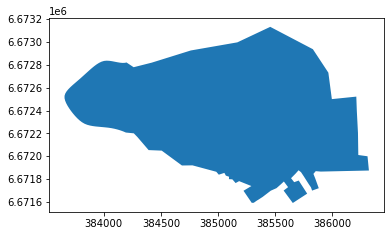

In [13]:
city_center_zip_area = postcode_areas.loc[postcode_areas['posti_alue']=='00100']
city_center_zip_area.plot();

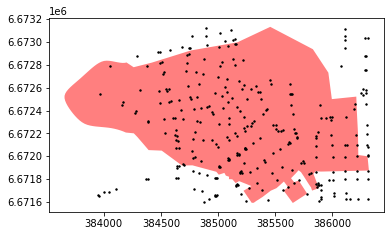

In [14]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(city_center_zip_area.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(intersection_sindex.intersection(bounds))
point_candidates = intersections.loc[point_candidate_idx]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

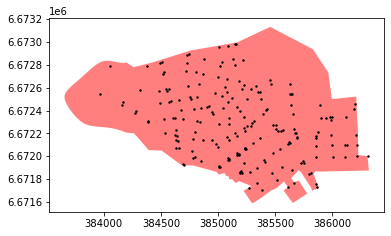

In [15]:
# Make the precise Point in Polygon query
final_selection = point_candidates.loc[point_candidates.intersects(city_center_zip_area['geometry'].values[0])]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = final_selection.plot(ax=ax, color='black', markersize=2)

In [18]:
# Count intersections by postal code area
intersection_cnt = gpd.sjoin(postcode_areas, intersections).groupby('posti_alue').size().reset_index()
intersection_cnt.head()

,posti_alue,0
0,00100,203
1,00120,35
2,00130,50
3,00140,44
4,00150,68


In [19]:
intersection_cnt = intersection_cnt.rename(columns={0: 'intersection_cnt'})
postcode_areas = postcode_areas.merge(intersection_cnt, on='posti_alue')
postcode_areas

,posti_alue,he_vakiy,geometry,intersection_cnt
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68
...,...,...,...,...
338,25470,279.0,"MULTIPOLYGON (((305067.212 6673543.615, 304620...",16
339,25500,3391.0,"MULTIPOLYGON (((277988.374 6665076.564, 277959...",86
340,25560,208.0,"MULTIPOLYGON (((294139.092 6671931.426, 291442...",48
341,31350,235.0,"MULTIPOLYGON (((329443.822 6726297.286, 329125...",2


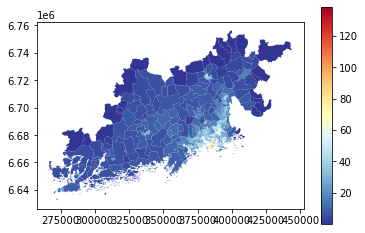

In [22]:
# Plot intersection density (number of intersections per square kilometer inside a Postal code)
m2_to_km2_converter = 1000000
postcode_areas['intersection_density'] = postcode_areas['intersection_cnt'] / (postcode_areas.area / m2_to_km2_converter)
postcode_areas.plot('intersection_density', cmap='RdYlBu_r', legend=True);